In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve)

In [6]:
print("Upload your heart.csv file (use the file selector).")
uploaded = files.upload()   # choose heart.csv from your machine

# If the uploaded filename is different, adjust this line accordingly
df = pd.read_csv('heart.csv')
print("\nLoaded dataset shape:", df.shape)
df.head()

Upload your heart.csv file (use the file selector).


Saving heart.csv to heart (1).csv

Loaded dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [7]:
df = df.replace('?', np.nan)

# Try to coerce numeric columns that may be strings
for col in df.columns:
    if df[col].dtype == object:
        # try convertable columns
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass

print("\nData types and non-null counts:")
display(df.info())

print("\nBasic statistics:")
display(df.describe(include='all').T)

print("\nMissing values per column:")
display(df.isnull().sum())


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None


Basic statistics:


,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2



Missing values per column:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [8]:
# ====== Cell 4: Handle missing values and duplicates ======
# Strategy: If very few missing -> drop, otherwise impute median (for numeric)
# Check percent missing
missing_percent = df.isnull().mean() * 100
print("Missing percent per column (%):")
display(missing_percent)

# If missing values are small in number, drop rows; else impute numeric with median
num_missing = df.isnull().sum().sum()
print(f"\nTotal missing entries: {num_missing}")

# We'll impute numeric columns with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

# For object/categorical columns, fill with mode
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].mode()[0])

# Drop duplicates if any
duplicates = df.duplicated().sum()
print(f"\nDuplicates found: {duplicates}")
if duplicates:
    df.drop_duplicates(inplace=True)

print("\nMissing values after imputation:")
display(df.isnull().sum())
print("\nShape after cleaning:", df.shape)


Missing percent per column (%):


,0
age,0.0
sex,0.0
cp,0.0
trestbps,0.0
chol,0.0
fbs,0.0
restecg,0.0
thalach,0.0
exang,0.0
oldpeak,0.0



Total missing entries: 0

Duplicates found: 723

Missing values after imputation:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0



Shape after cleaning: (302, 14)


Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Target distribution:


,count
target,
1,164
0,138


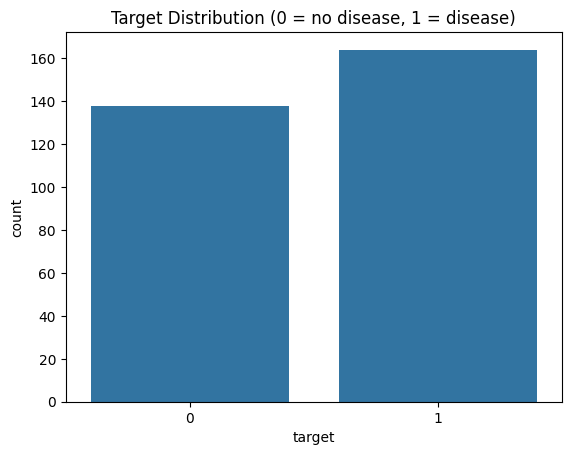

In [9]:
# ====== Cell 5: Rename target (if needed) and inspect columns ======
# Typical UCI column names: age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang,
# oldpeak, slope, ca, thal, target (0 = no disease, 1 = disease)
print("Columns:", df.columns.tolist())

# If target isn't named 'target', try to detect common names
if 'target' not in df.columns and 'HeartDisease' in df.columns:
    df.rename(columns={'HeartDisease': 'target'}, inplace=True)

# Show target distribution
print("\nTarget distribution:")
display(df['target'].value_counts())
sns.countplot(x='target', data=df)
plt.title('Target Distribution (0 = no disease, 1 = disease)')
plt.show()

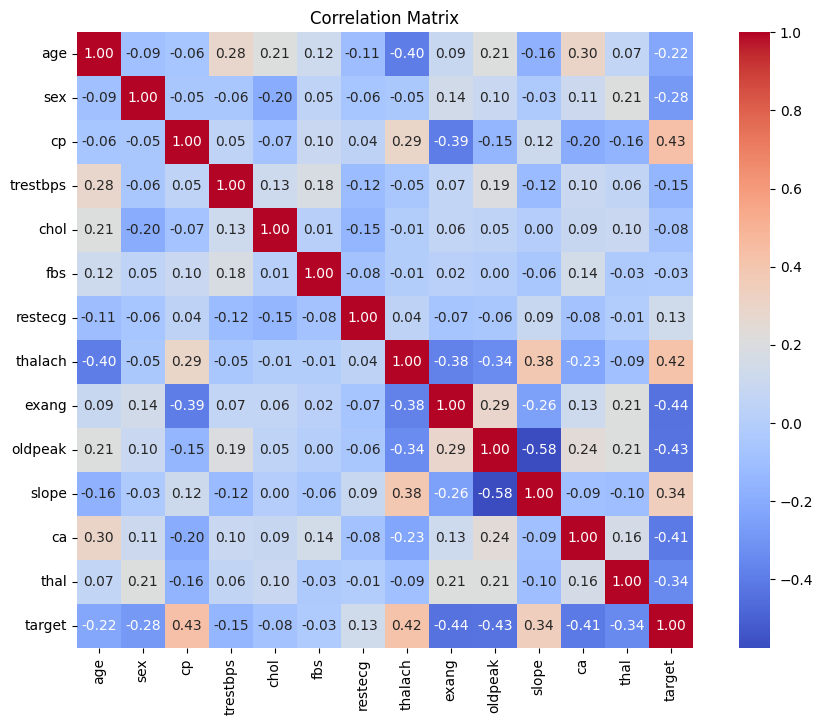

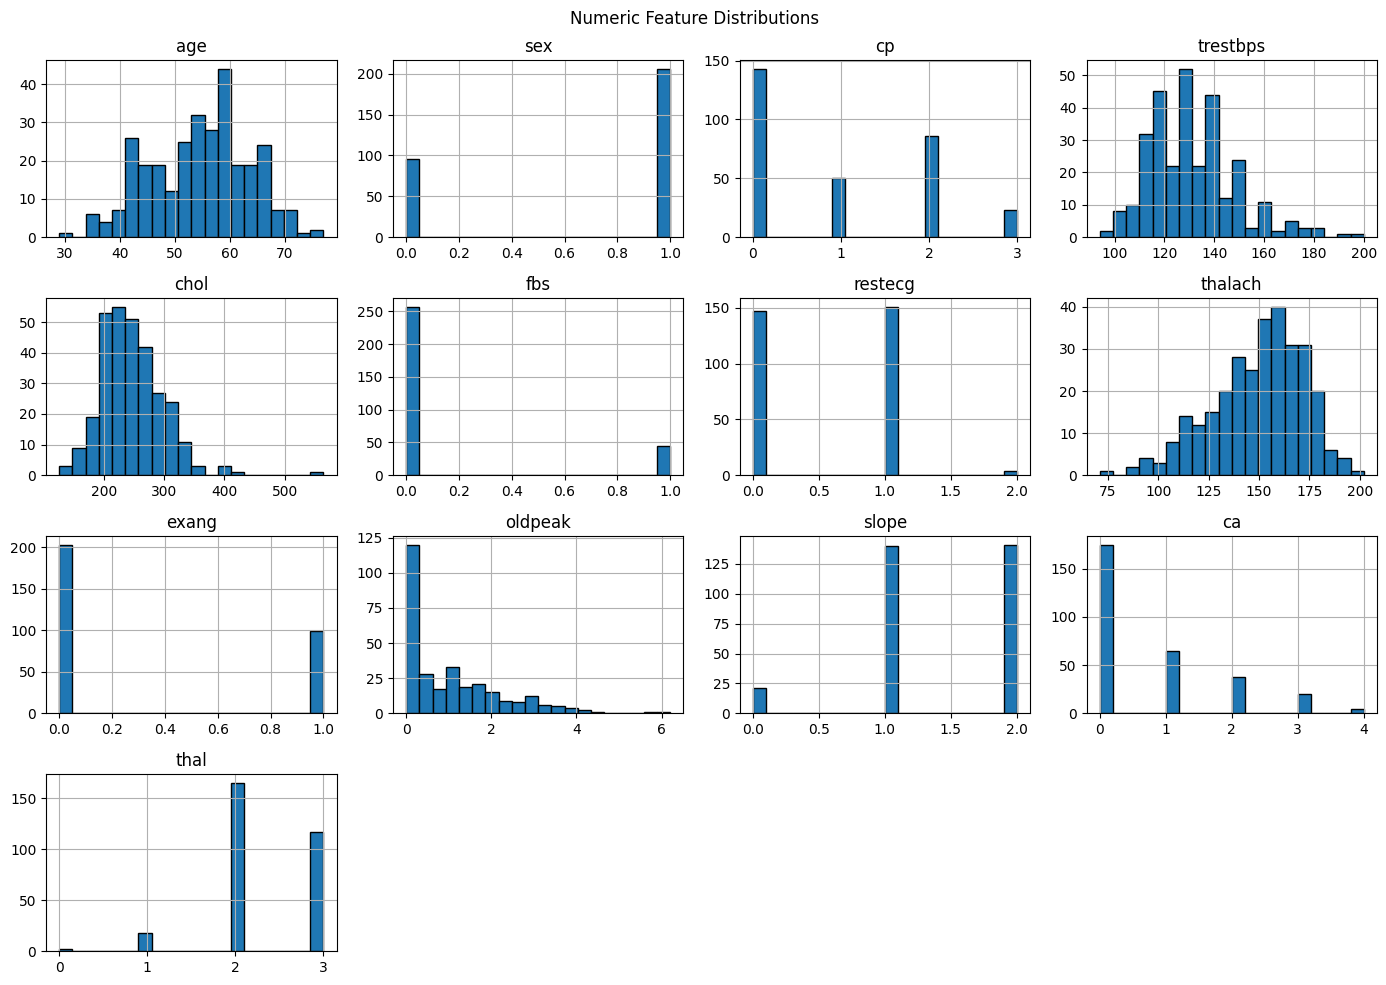

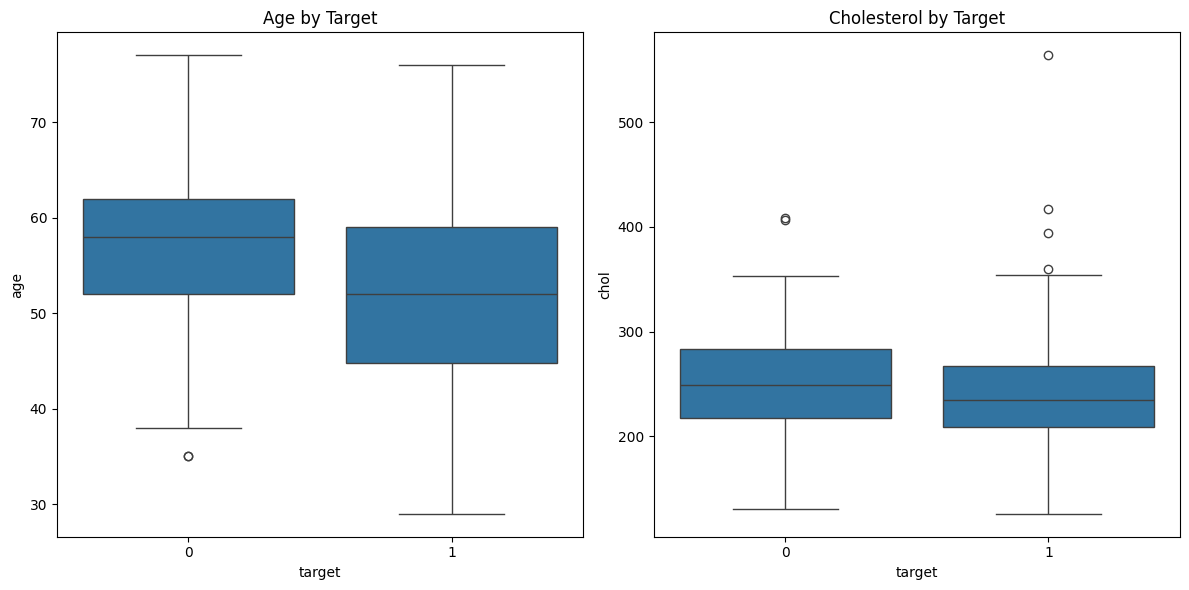

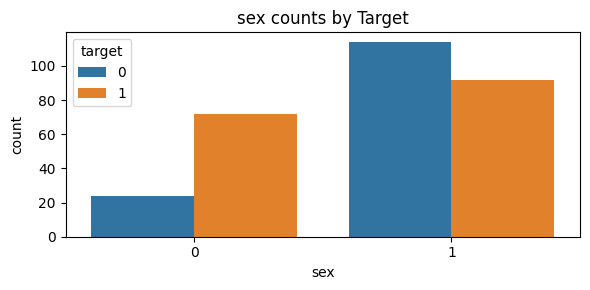

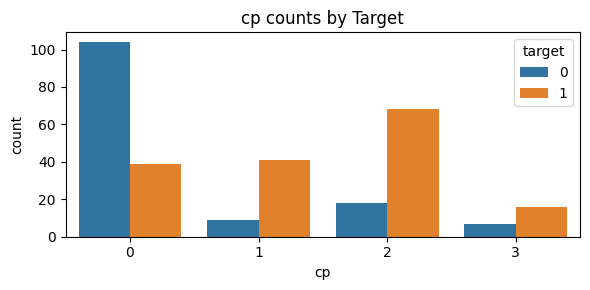

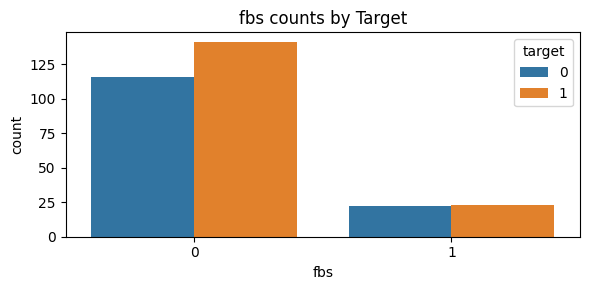

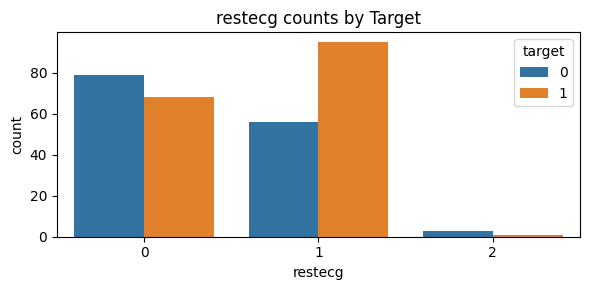

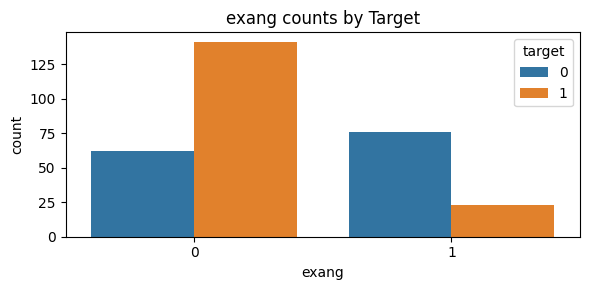

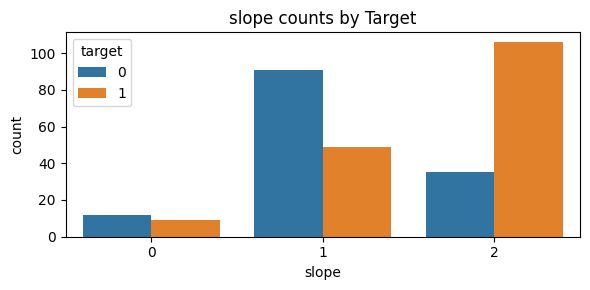

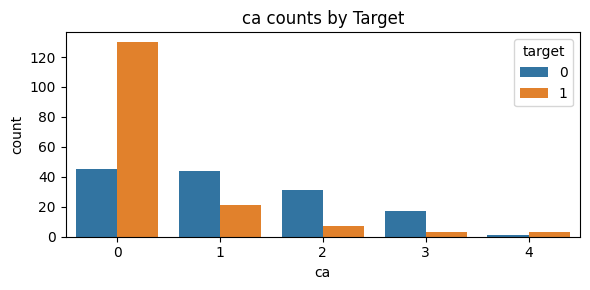

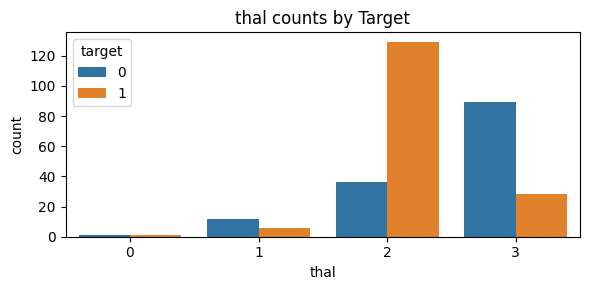

In [10]:
# ====== Cell 6: Exploratory Data Analysis (EDA) ======
# Correlation heatmap for numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Histograms of numeric features
num_features = df.select_dtypes(include=[np.number]).columns.drop('target')
df[num_features].hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle('Numeric Feature Distributions')
plt.tight_layout()
plt.show()

# Boxplots for a few selected variables vs target
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='age', data=df)
plt.title('Age by Target')
plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='chol', data=df)
plt.title('Cholesterol by Target')
plt.tight_layout()
plt.show()

# Categorical feature counts (if any)
for col in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} counts by Target')
        plt.tight_layout()
        plt.show()


In [11]:
# ====== Cell 7: Preprocessing - feature & target setup ======
# Separate X and y
X = df.drop('target', axis=1)
y = df['target']

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# treat small-integer-coded columns as categorical if appropriate
maybe_cat = [c for c in numeric_cols if X[c].nunique() <= 6 and c not in ('age', 'trestbps','chol','thalach','oldpeak')]
# decide categorical columns (common heart dataset: sex, cp, fbs, restecg, exang, slope, ca, thal)
categorical_cols = [c for c in X.columns if c in ['sex','cp','fbs','restecg','exang','slope','ca','thal']]
# fallback to intersection
categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [13]:
# ====== Cell 8: Build preprocessing pipeline ======
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

preprocessor.fit(X)

# feature names for debugging
ohe = preprocessor.named_transformers_['cat'].named_steps.get('onehot')
cat_feature_names = ohe.get_feature_names_out(categorical_cols) if categorical_cols else []

final_feature_names = numeric_cols + list(cat_feature_names)

print("Final feature count after preprocessing:", len(final_feature_names))


Final feature count after preprocessing: 30


In [14]:
# ====== Cell 9: Train / test split ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (241, 13)
Test shape: (61, 13)


In [15]:
# ====== Cell 10: Modeling pipelines for Decision Tree & Random Forest ======
# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Quick baseline fit (default params)
dt_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

dt_pred = dt_pipeline.predict(X_test)
rf_pred = rf_pipeline.predict(X_test)

print("Decision Tree accuracy (default):", accuracy_score(y_test, dt_pred))
print("Random Forest accuracy (default):", accuracy_score(y_test, rf_pred))


Decision Tree accuracy (default): 0.7377049180327869
Random Forest accuracy (default): 0.8032786885245902


In [16]:
# ====== Cell 11: Hyperparameter tuning with GridSearchCV ======
# Keep grids small so training is fast in Colab; expand locally if needed.
dt_param_grid = {
    'clf__max_depth': [3, 5, 7, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 6, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

print("Running GridSearch for Decision Tree (this may take a moment)...")
dt_grid.fit(X_train, y_train)
print("Best DT params:", dt_grid.best_params_)
print("Best DT CV score:", dt_grid.best_score_)

print("\nRunning GridSearch for Random Forest (this may take a bit longer)...")
rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF CV score:", rf_grid.best_score_)


Running GridSearch for Decision Tree (this may take a moment)...
Best DT params: {'clf__max_depth': 7, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best DT CV score: 0.7882653061224489

Running GridSearch for Random Forest (this may take a bit longer)...
Best RF params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best RF CV score: 0.8463435374149659



--- Decision Tree (tuned) Evaluation ---
Accuracy: 0.7540983606557377
Precision: 0.8
Recall: 0.7272727272727273
F1-score: 0.7619047619047619

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.80      0.73      0.76        33

    accuracy                           0.75        61
   macro avg       0.75      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61



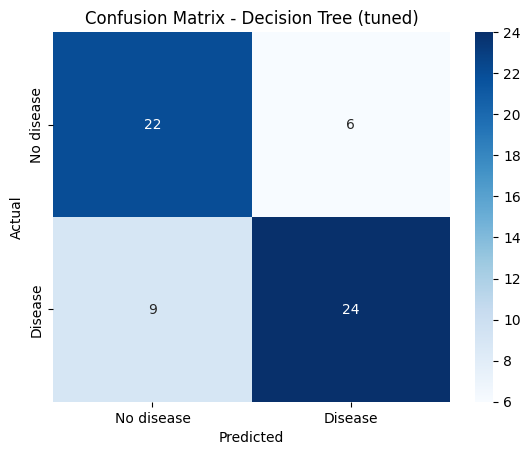


--- Random Forest (tuned) Evaluation ---
Accuracy: 0.7868852459016393
Precision: 0.7941176470588235
Recall: 0.8181818181818182
F1-score: 0.8059701492537313

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



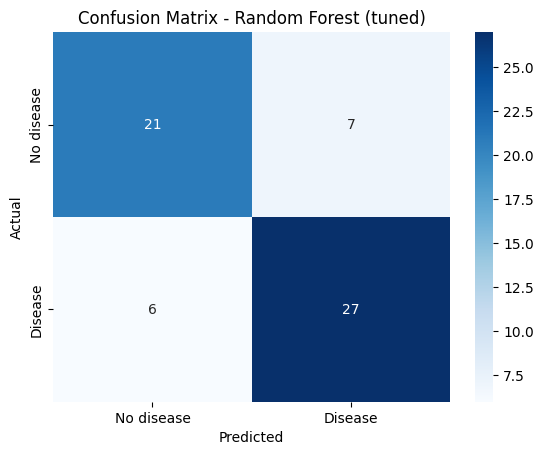

In [17]:
# ====== Cell 12: Evaluate best models on test set ======
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

def print_evaluation(y_true, y_pred, model_name):
    print(f"\n--- {model_name} Evaluation ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No disease','Disease'], yticklabels=['No disease','Disease'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

print_evaluation(y_test, y_pred_dt, 'Decision Tree (tuned)')
print_evaluation(y_test, y_pred_rf, 'Random Forest (tuned)')


Decision Tree ROC AUC: 0.8160
Random Forest ROC AUC: 0.8810


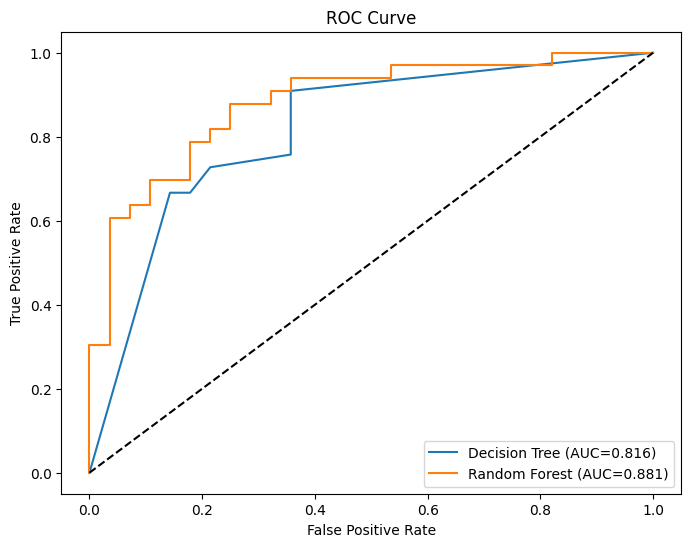

In [18]:
# ====== Cell 13: ROC AUC comparison ======
# For ROC we need probability estimates
y_prob_dt = best_dt.predict_proba(X_test)[:,1]
y_prob_rf = best_rf.predict_proba(X_test)[:,1]

dt_auc = roc_auc_score(y_test, y_prob_dt)
rf_auc = roc_auc_score(y_test, y_prob_rf)
print(f"Decision Tree ROC AUC: {dt_auc:.4f}")
print(f"Random Forest ROC AUC: {rf_auc:.4f}")

# Plot ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={dt_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


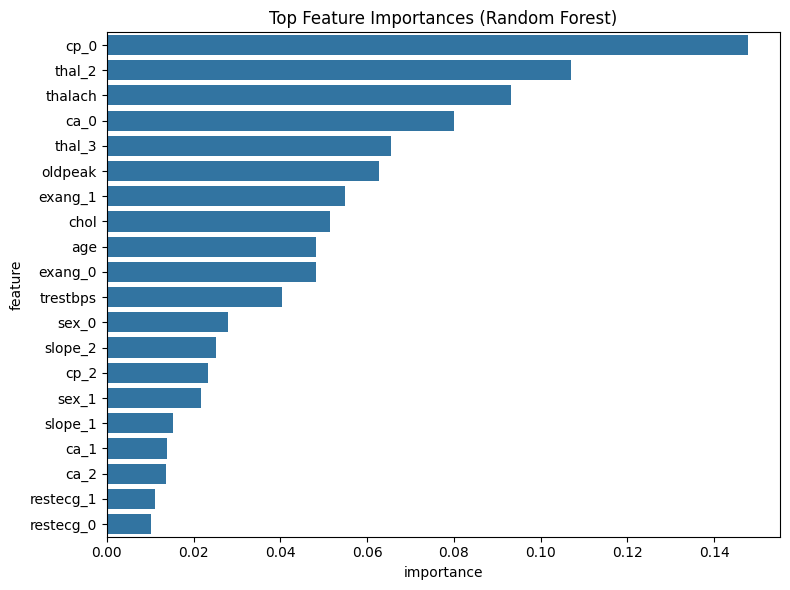

,feature,importance
7,cp_0,0.147775
28,thal_2,0.106911
3,thalach,0.093108
21,ca_0,0.080056
29,thal_3,0.065486
4,oldpeak,0.062758
17,exang_1,0.054807
2,chol,0.051498
0,age,0.048286
16,exang_0,0.048279


In [19]:
# ====== Cell 14: Feature importance (Random Forest) ======
# Get feature importances from the RF pipeline
# Need the preprocessor + classifier pipeline; extract feature names
importances = None
if hasattr(best_rf.named_steps['clf'], 'feature_importances_'):
    rf_importances = best_rf.named_steps['clf'].feature_importances_
    # Get processed feature names (numeric + onehot)
    processed_X = preprocessor.transform(X.head(1))  # just to access transformer shapes
    # We built final_feature_names earlier; reuse logic to create names
    # (Recompute to be safe)
    cat_names = []
    if categorical_cols:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(categorical_cols))
    feat_names = numeric_cols + cat_names
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': rf_importances})
    fi_df = fi_df.sort_values('importance', ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(data=fi_df, x='importance', y='feature')
    plt.title('Top Feature Importances (Random Forest)')
    plt.tight_layout()
    plt.show()
    display(fi_df)
else:
    print("Best RF model does not expose feature_importances_.")


In [20]:
# ====== Cell 15: Cross-validation scores for final models ======
cv_dt = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy', n_jobs=-1)
cv_rf = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Decision Tree CV accuracy: %.4f ± %.4f" % (cv_dt.mean(), cv_dt.std()*2))
print("Random Forest CV accuracy: %.4f ± %.4f" % (cv_rf.mean(), cv_rf.std()*2))


Decision Tree CV accuracy: 0.7219 ± 0.1248
Random Forest CV accuracy: 0.8508 ± 0.1019


In [21]:
# ====== Cell 16: Save cleaned dataset and optionally export models ======
# Save cleaned data
df.to_csv('cleaned_heart_dataset.csv', index=False)
files.download('cleaned_heart_dataset.csv')
print("Cleaned dataset saved: cleaned_heart_dataset.csv")

# Optionally, save the best model with joblib (uncomment to use)
# from joblib import dump
# dump(best_rf, 'best_rf_model.joblib')
# files.download('best_rf_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cleaned dataset saved: cleaned_heart_dataset.csv


In [22]:
# ====== Cell 17: Short conclusion template (copy to your notebook text) ======
conclusion_text = """
Conclusion:
- Both Decision Tree and Random Forest were trained and tuned on the Heart Disease dataset.
- Random Forest typically gives better generalization, shown by higher validation and CV accuracy, and better ROC AUC.
- Decision Tree is easier to interpret (visualize the tree) but is more prone to overfitting.
- Feature importance highlights which features contribute most to predictions (e.g., thalach, cp, oldpeak, age, etc. — check your dataset-specific results).
- Next steps: try stratified k-fold, SMOTE for class imbalance (if present), try XGBoost, and produce a short presentation summarizing EDA, metric table, and final recommendation.
"""
print(conclusion_text)



Conclusion:
- Both Decision Tree and Random Forest were trained and tuned on the Heart Disease dataset.
- Random Forest typically gives better generalization, shown by higher validation and CV accuracy, and better ROC AUC.
- Decision Tree is easier to interpret (visualize the tree) but is more prone to overfitting.
- Feature importance highlights which features contribute most to predictions (e.g., thalach, cp, oldpeak, age, etc. — check your dataset-specific results).
- Next steps: try stratified k-fold, SMOTE for class imbalance (if present), try XGBoost, and produce a short presentation summarizing EDA, metric table, and final recommendation.

